{'x': 6.0, 'y': 7.0, 'sustainability_score': 50.41, 'puntuacion': 4.0}


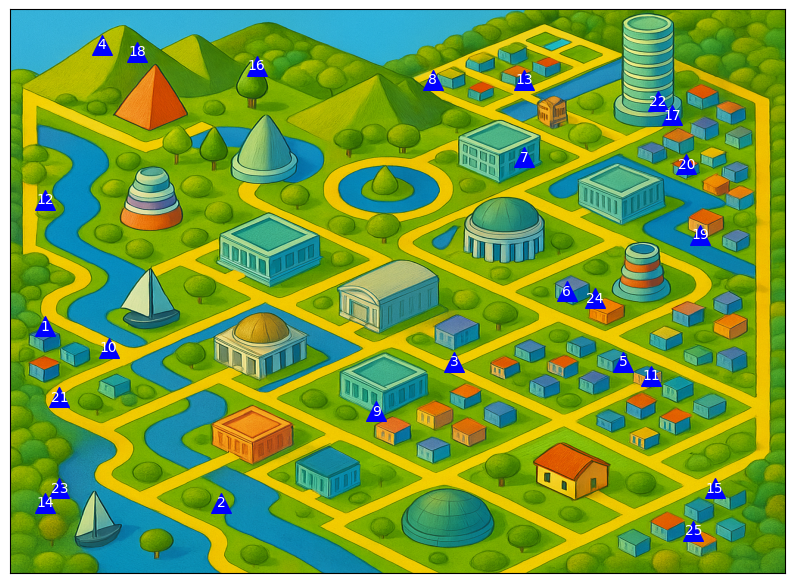

In [10]:
import tkinter as tk
import networkx as nx
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
from tkinter import messagebox
import json

# -------------------- DATA PREPARATION -------------------- #
df_data = pd.read_csv("data/rutas_turisticas.csv")
df_data["clean_name"] = df_data["ruta_nombre"].str.split(" - ").str[0].str.strip()

place_info = df_data.groupby("clean_name").agg({
    "tipo_ruta": "first",
    "duracion_hr": "mean",
    "popularidad": "mean"
}).reset_index()

info_dict = {
    row["clean_name"]: {
        "tipo_ruta": row["tipo_ruta"],
        "duracion_hr": round(row["duracion_hr"], 1),
        "popularidad": round(row["popularidad"], 1)
    }
    for _, row in place_info.iterrows()
}

nodes_coords = {
    'Ezmeral Valley': (1.5, 6.5), 'Apollo Heights': (2.6, 3),
    'Nimble Peak': (4.3, 5.8), 'Aruba Central': (2.6, 5.2),
    'ProLiant Village': (5.5, 3.5), 'GreenLake Shores': (5.6, 4.9),
    'Simplivity Springs': (8.9, 1.1), 'Composable Cloud': (5.3, 1.2),
    'Alletra City': (4.6, 2.2), 'HPE Innovation Hub': (8.4, 6.6)
}

node_names = list(nodes_coords.keys())
numbered_nodes = {name: str(i + 1) for i, name in enumerate(node_names)}
reverse_numbered = {v: k for k, v in numbered_nodes.items()}

G_base = nx.Graph()
for name, coord in nodes_coords.items():
    number = numbered_nodes[name]
    G_base.add_node(number, pos=coord)

pos = nx.get_node_attributes(G_base, 'pos')

hotel_coordinates = pd.read_csv("data/Hotel_Coordinates.csv")
hotels_scores = pd.read_csv("data/score_and_punctuation.csv")
merged_hotels = pd.merge(hotel_coordinates, hotels_scores, on="hotel_nombre")


hotel_dict = merged_hotels.set_index("hotel_nombre").to_dict(orient="index")
hotel_names = list(hotel_dict.keys())
numbered_hotels = {name: str(i + 1) for i, name in enumerate(hotel_names)}
reverse_numbered_hotels = {v: k for k, v in numbered_hotels.items()}

G_base1 = nx.Graph()
for name, dict in hotel_dict.items():
    number = numbered_hotels[name]
    coords = (dict["x"], dict["y"])
    G_base1.add_node(number, pos=coords)

pos1 = nx.get_node_attributes(G_base1, 'pos')

# Load transport data
df_transport = pd.read_csv("data/uso_transporte.csv")
df_transport["clean_ruta"] = df_transport["ruta_popular"].str.replace('\xa0', ' ')
df_transport[["origen", "destino"]] = df_transport["clean_ruta"].str.split(" - ", expand=True)
df_transport["origen"] = df_transport["origen"].str.strip()
df_transport["destino"] = df_transport["destino"].str.strip()

# -------------------- WINDOWS AS CLASSES -------------------- #

class HosteleriaWindow:
    def __init__(self, master):
        self.window = tk.Toplevel(master)
        self.window.title("Hostelería")

        self.left_frame = tk.Frame(self.window)
        self.left_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        self.right_frame = tk.Frame(self.window)
        self.right_frame.pack(side=tk.RIGHT, fill=tk.Y)

        fig, ax = plt.subplots(figsize=(10, 8))
        bg_img = mpimg.imread("Green_Lake_Village.png")
        ax.imshow(bg_img, extent=[0, 11, 0, 8])

        node_collection = nx.draw_networkx_nodes(G_base1, pos1, node_color='blue', node_shape='^', node_size=200, ax=ax)
        node_collection.set_picker(True)
        nx.draw_networkx_labels(G_base1, pos1, font_size=10, font_color='white', ax=ax)

        canvas = FigureCanvasTkAgg(fig, master=self.left_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

        # Hotel list on the right
        tk.Label(self.right_frame, text="Información de los hoteles", font=('Arial', 12, 'bold')).pack(pady=(10, 5))
        for name, number in numbered_hotels.items():
            tk.Label(self.right_frame, text=f"{number}. {name}", anchor='w', font=('Arial', 10)).pack(anchor='w', padx=10)

        def on_pick(event):
            ind = event.ind[0]
            node_number = list(G_base1.nodes())[ind]
            place_name = reverse_numbered_hotels[node_number]
            clean_name = place_name.strip()
            data = hotel_dict[place_name]
            print(data)
            #sustainability_score = info_dict.get("sustainability_score")
            #puntuacion = info_dict.get("puntuacion")
            if data:
                messagebox.showinfo(
                    title=f"Info about {clean_name}",
                    message=(
                        f"Nombre del hotel 🏨: {clean_name}\n"
                        f"Puntiacion de sostenabilidad 🌿: {data['sustainability_score']}\n"
                        f"Puntuacion ⭐: {data['puntuacion']}\n"
                    )
                )
            else:
                messagebox.showinfo("No Data", f"No info available for {clean_name}")

        fig.canvas.mpl_connect('pick_event', on_pick)


class ZonasTuristicasWindow:
    def __init__(self, master):
        self.window = tk.Toplevel(master)
        self.window.title("Zonas Turísticas")

        self.left_frame = tk.Frame(self.window)
        self.left_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        self.right_frame = tk.Frame(self.window)
        self.right_frame.pack(side=tk.RIGHT, fill=tk.Y)

        fig, ax = plt.subplots(figsize=(10, 8))
        bg_img = mpimg.imread("Green_Lake_Village.png")
        ax.imshow(bg_img, extent=[0, 11, 0, 8])

        node_collection = nx.draw_networkx_nodes(G_base, pos, node_color='red', node_shape='v', node_size=500, ax=ax)
        node_collection.set_picker(True)
        nx.draw_networkx_labels(G_base, pos, font_size=10, font_color='black', ax=ax)

        canvas = FigureCanvasTkAgg(fig, master=self.left_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

        tk.Label(self.right_frame, text="Node Legend", font=('Arial', 12, 'bold')).pack(pady=(10, 5))
        for name, number in numbered_nodes.items():
            tk.Label(self.right_frame, text=f"{number}. {name}", anchor='w', font=('Arial', 10)).pack(anchor='w', padx=10)

        def on_pick(event):
            ind = event.ind[0]
            node_number = list(G_base.nodes())[ind]
            place_name = reverse_numbered[node_number]
            clean_name = place_name.strip()
            data = info_dict.get(clean_name)
            if data:
                messagebox.showinfo(
                    title=f"Info about {clean_name}",
                    message=(
                        f"Place: {clean_name}\n"
                        f"Type: {data['tipo_ruta']}\n"
                        f"Avg Duration: {data['duracion_hr']} hours\n"
                        f"Avg Popularity: {data['popularidad']}/5"
                    )
                )
            else:
                messagebox.showinfo("No Data", f"No info available for {clean_name}")

        fig.canvas.mpl_connect('pick_event', on_pick)


class TransporteWindow:
    def __init__(self, master):
        self.window = tk.Toplevel(master)
        self.window.title("Transporte")

        top_frame = tk.Frame(self.window)
        top_frame.pack(fill=tk.X, pady=10)

        tk.Label(top_frame, text="Tipo Transporte:").pack(side=tk.LEFT, padx=5)
        self.tipo_entry = tk.Entry(top_frame)
        self.tipo_entry.pack(side=tk.LEFT, padx=5)

        tk.Label(top_frame, text="De:").pack(side=tk.LEFT)
        self.from_entry = tk.Entry(top_frame, width=5)
        self.from_entry.pack(side=tk.LEFT, padx=2)

        tk.Label(top_frame, text="A:").pack(side=tk.LEFT)
        self.to_entry = tk.Entry(top_frame, width=5)
        self.to_entry.pack(side=tk.LEFT, padx=2)

        tk.Button(top_frame, text="Buscar", command=self.search_route).pack(side=tk.LEFT, padx=10)

        self.left_frame = tk.Frame(self.window)
        self.left_frame.pack(side=tk.LEFT, fill=tk.Y)
        self.result_box = tk.Text(self.left_frame, width=40, height=40)
        self.result_box.pack(padx=5, pady=5)

        self.right_frame = tk.Frame(self.window)
        self.right_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

        self.fig, self.ax = plt.subplots(figsize=(10, 8))
        bg_img = mpimg.imread("Green_Lake_Village.png")
        self.ax.imshow(bg_img, extent=[0, 11, 0, 8])

        nx.draw_networkx_nodes(G_base, pos, node_color='red', node_shape='v', node_size=500, ax=self.ax)
        nx.draw_networkx_labels(G_base, pos, font_size=10, font_color='black', ax=self.ax)

        self.canvas = FigureCanvasTkAgg(self.fig, master=self.right_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    def search_route(self):
        tipo = self.tipo_entry.get().strip()
        origen = self.from_entry.get().strip()
        destino = self.to_entry.get().strip()

        self.ax.clear()
        bg_img = mpimg.imread("Green_Lake_Village.png")
        self.ax.imshow(bg_img, extent=[0, 11, 0, 8])
        nx.draw_networkx_nodes(G_base, pos, node_color='red', node_shape='v', node_size=500, ax=self.ax)
        nx.draw_networkx_labels(G_base, pos, font_size=10, font_color='black', ax=self.ax)

        self.result_box.delete('1.0', tk.END)

        if origen and destino:
            if tipo:
                self.draw_path_for_type(tipo, origen, destino)
            else:
                best_paths = []
                for tipo_actual in df_transport['tipo_transporte'].unique():
                    result = self.draw_path_for_type(tipo_actual, origen, destino, draw=False)
                    if result:
                        best_paths.append((tipo_actual, result))

                if best_paths:
                    best_paths.sort(key=lambda x: x[1]['total_time'])
                    for tipo_actual, data in best_paths:
                        self.result_box.insert(tk.END, f"{tipo_actual.title()} ({data['total_time']} min):\n")
                        self.result_box.insert(tk.END, " → ".join(data['path']) + "\n\n")
                        for u, v in zip(data['path'][:-1], data['path'][1:]):
                            self.ax.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]], linewidth=2)

        self.canvas.draw()

    def draw_path_for_type(self, tipo, origen, destino, draw=True):
        filtered = df_transport[df_transport['tipo_transporte'].str.lower() == tipo.lower()]

        G_temp = nx.DiGraph()
        for _, row in filtered.iterrows():
            src = numbered_nodes.get(row['origen'])
            dst = numbered_nodes.get(row['destino'])
            if src and dst:
                G_temp.add_edge(src, dst, weight=row['tiempo_viaje_promedio_min'])

        if origen in G_temp.nodes and destino in G_temp.nodes:
            try:
                path = nx.shortest_path(G_temp, origen, destino, weight='weight')
                total_time = sum(G_temp[u][v]['weight'] for u, v in zip(path[:-1], path[1:]))
                if draw:
                    self.result_box.insert(tk.END, f"{tipo.title()} ({total_time} min):\n")
                    self.result_box.insert(tk.END, " → ".join(path) + "\n\n")
                    for u, v in zip(path[:-1], path[1:]):
                        self.ax.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]], linewidth=2)
                return {'path': path, 'total_time': total_time}
            except nx.NetworkXNoPath:
                if draw:
                    self.result_box.insert(tk.END, f"{tipo.title()}: No existe ruta.\n\n")
        return None


class LandingPage:
    def __init__(self):
        self.window = tk.Tk()
        self.window.title("Landing Page")
        self.window.geometry("300x250")

        tk.Label(self.window, text="Bienvenido", font=("Arial", 16, "bold")).pack(pady=20)

        tk.Button(self.window, text="Hostelería", width=20, command=lambda: HosteleriaWindow(self.window)).pack(pady=5)
        tk.Button(self.window, text="Transporte", width=20, command=lambda: TransporteWindow(self.window)).pack(pady=5)
        tk.Button(self.window, text="Zonas Turísticas", width=20, command=lambda: ZonasTuristicasWindow(self.window)).pack(pady=5)

        self.window.mainloop()

if __name__ == '__main__':
    LandingPage()